In [16]:
import umap
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as hier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

PATH_TO_12MUTSPEC = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/ms12syn_internal_iqtree.tsv'
PATH_TO_METADATA = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/msMetaData.tsv'

In [17]:
meta_df = pd.read_csv(PATH_TO_METADATA, sep='\t').sort_values(by='Species')
mutspec12 = pd.read_csv(PATH_TO_12MUTSPEC, sep='\t')
mutspec12 = mutspec12.sort_values(['Species', 'Mut'])

In [18]:
# inverts nucls for ms12, needs to be run only once. DEW IT!

a_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'A>G'], mutspec12[mutspec12['Mut'] == 'A>C'], mutspec12[mutspec12['Mut'] == 'A>T']])
t_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'T>G'], mutspec12[mutspec12['Mut'] == 'T>C'], mutspec12[mutspec12['Mut'] == 'T>A']])
g_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'G>T'], mutspec12[mutspec12['Mut'] == 'G>C'], mutspec12[mutspec12['Mut'] == 'G>A']])
c_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'C>T'], mutspec12[mutspec12['Mut'] == 'C>G'], mutspec12[mutspec12['Mut'] == 'C>A']])

a_spec.loc[a_spec['Mut'] == 'A>G', 'Mut'] = 'T>C'
a_spec.loc[a_spec['Mut'] == 'A>C', 'Mut'] = 'T>G'
a_spec.loc[a_spec['Mut'] == 'A>T', 'Mut'] = 'T>A'

t_spec.loc[t_spec['Mut'] == 'T>G', 'Mut'] = 'A>C'
t_spec.loc[t_spec['Mut'] == 'T>C', 'Mut'] = 'A>G'
t_spec.loc[t_spec['Mut'] == 'T>A', 'Mut'] = 'A>T'

g_spec.loc[g_spec['Mut'] == 'G>T', 'Mut'] = 'C>A'
g_spec.loc[g_spec['Mut'] == 'G>C', 'Mut'] = 'C>G'
g_spec.loc[g_spec['Mut'] == 'G>A', 'Mut'] = 'C>T'

c_spec.loc[c_spec['Mut'] == 'C>T', 'Mut'] = 'G>A'
c_spec.loc[c_spec['Mut'] == 'C>G', 'Mut'] = 'G>C'
c_spec.loc[c_spec['Mut'] == 'C>A', 'Mut'] = 'G>T'

mutspec12 = pd.concat([a_spec, t_spec, g_spec, c_spec]).sort_values(by=['Species', 'Mut'])

In [19]:
def chop(l, chunk_size):
    for i in range(0, len(l), chunk_size):
        yield l[i:i + chunk_size]

In [20]:
#removing species with less than 15 total mutations
mut_ammount_df = mutspec12.groupby(mutspec12['Species']).aggregate({'ObsNum' : 'sum'}).reset_index()
less_than_15_total_muts = mut_ammount_df.drop(mut_ammount_df[mut_ammount_df['ObsNum'] > 15].index)['Species'].to_list()
for sp in less_than_15_total_muts:
    mutspec12 = mutspec12.drop(mutspec12[mutspec12['Species'] == sp].index)
    meta_df = meta_df.drop(meta_df[meta_df['Species'] == sp].index)

#removing species with less than 4 mutation types
species = mutspec12['Species'].drop_duplicates().to_list()
obsnum_values = mutspec12['ObsNum'].to_list()
chopped_obsnum =  list(chop(obsnum_values, 12))

species_and_obsnum = {}
for i in range(len(species)):
    species_and_obsnum[species[i]] = chopped_obsnum[i]

less_than_4_mut_types = []
for sp, obsnum_list in species_and_obsnum.items():
    if obsnum_list.count(0) > 8:
        less_than_4_mut_types.append(sp)

for sp in less_than_4_mut_types:
    mutspec12 = mutspec12.drop(mutspec12[mutspec12['Species'] == sp].index)
    meta_df = meta_df.drop(meta_df[meta_df['Species'] == sp].index)

#half-assed way of converting the table into what I need
mutspec_vals = mutspec12['MutSpec'].to_list()
muts = mutspec12['Mut'].to_list()[0:12]
species = mutspec12['Species'].drop_duplicates().to_list() #need to reset after removing species

chopped_values = list(chop(mutspec_vals, 12))
df_prep = {}
for i in range(len(species)):
    df_prep[species[i]] = chopped_values[i]
df = pd.DataFrame(df_prep)
df = df.T
df.columns = muts
df = df.fillna(0)


In [21]:
#save data for R
df.to_csv("/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/mutspec_as_header_12internal.csv")

/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr

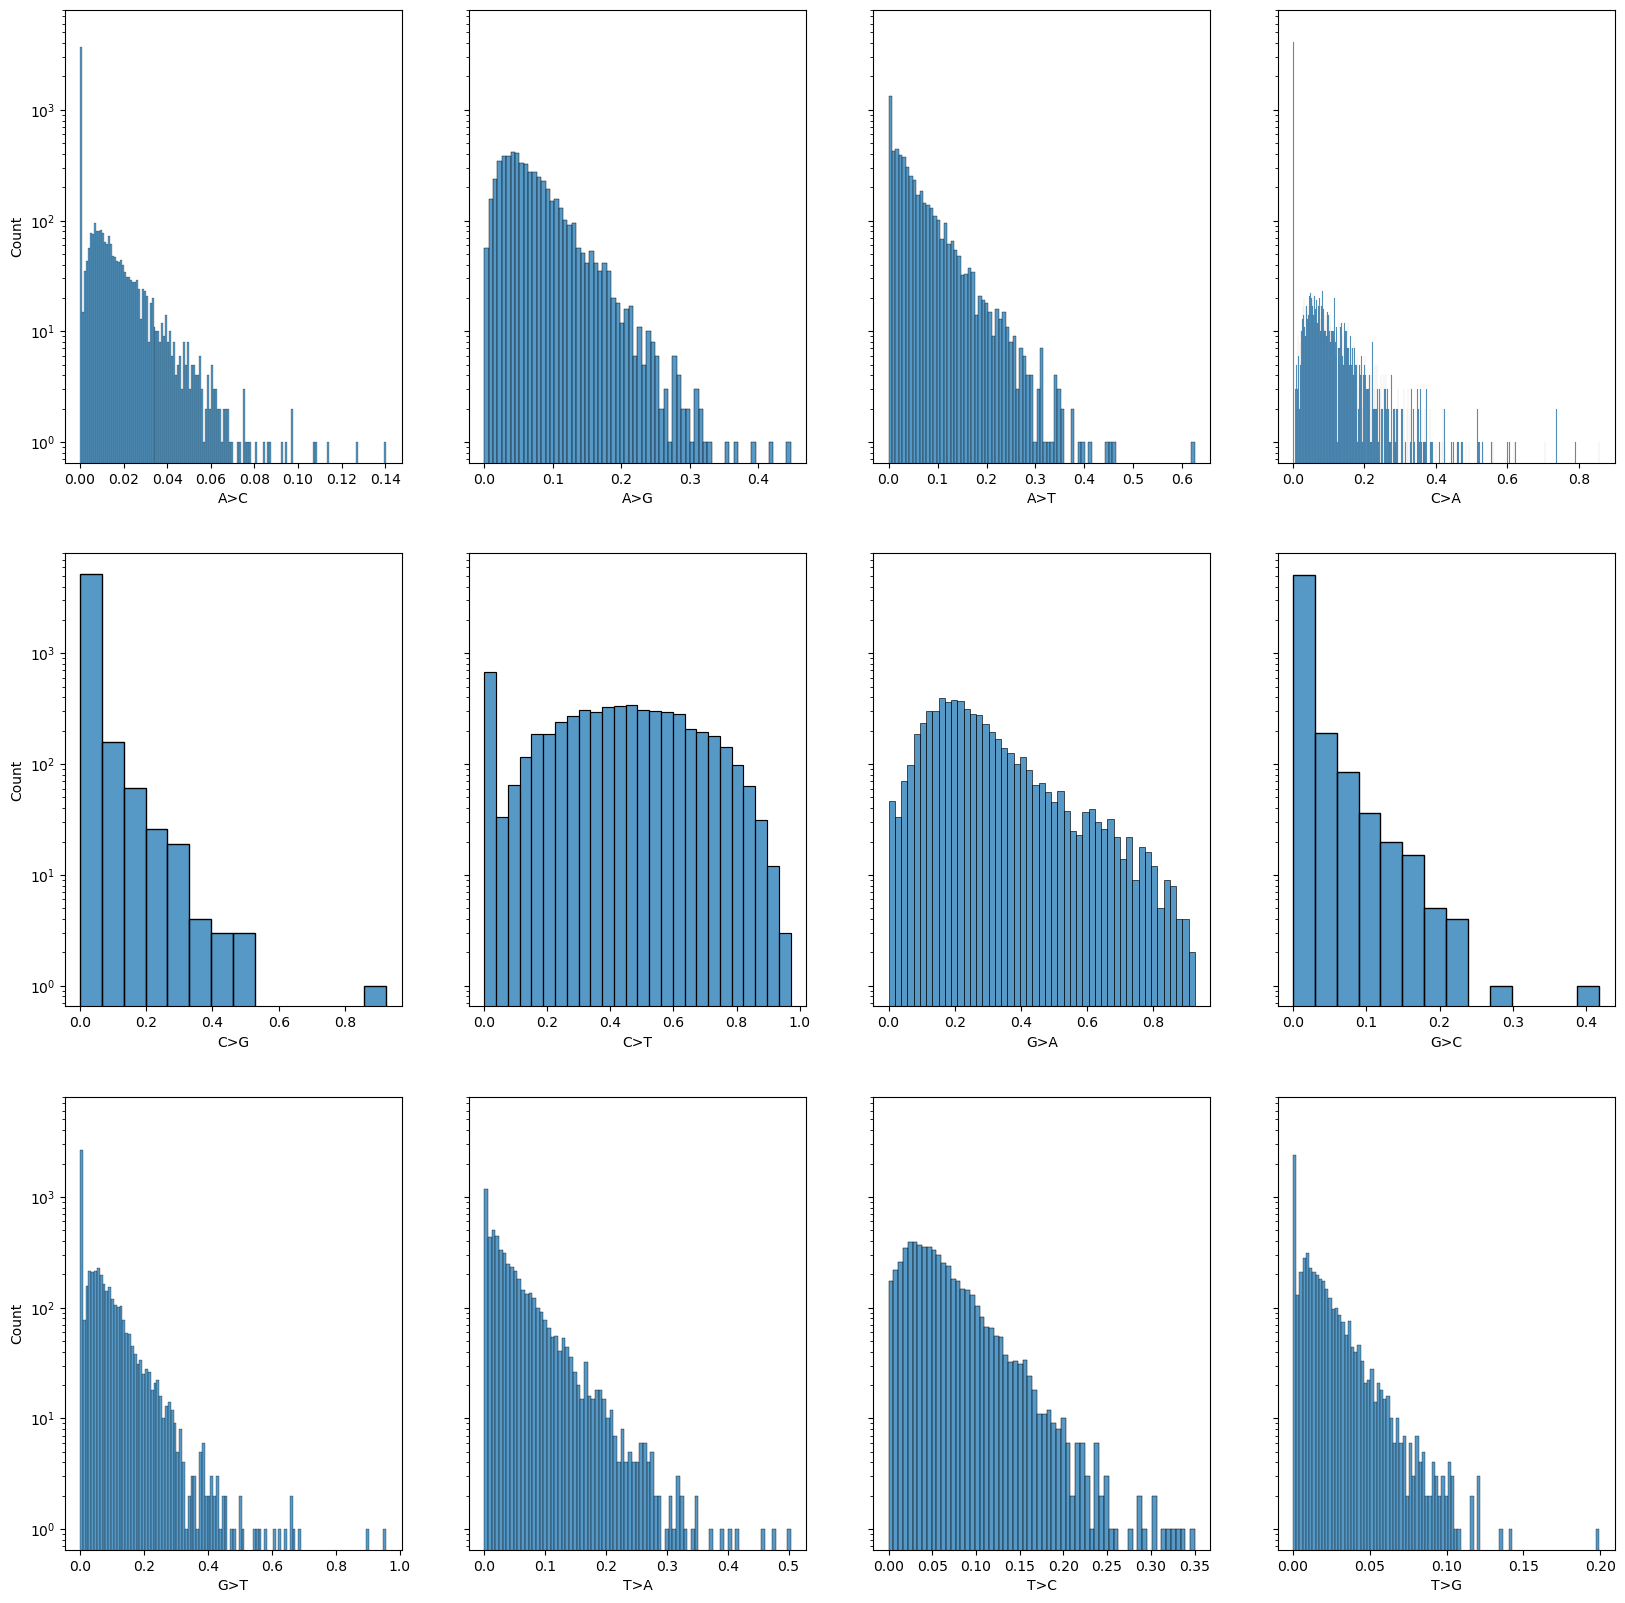

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20,20), sharey=True)
sns.histplot(df, x='A>C', ax=axs[0][0])
sns.histplot(df, x='A>G', ax=axs[0][1])
sns.histplot(df, x='A>T', ax=axs[0][2])
sns.histplot(df, x='C>A', ax=axs[0][3])
sns.histplot(df, x='C>G', ax=axs[1][0])
sns.histplot(df, x='C>T', ax=axs[1][1])
sns.histplot(df, x='G>A', ax=axs[1][2])
sns.histplot(df, x='G>C', ax=axs[1][3])
sns.histplot(df, x='G>T', ax=axs[2][0])
sns.histplot(df, x='T>A', ax=axs[2][1])
sns.histplot(df, x='T>C', ax=axs[2][2])
sns.histplot(df, x='T>G', ax=axs[2][3])
plt.yscale('log')

In [4]:
scaled = preprocessing.scale(df)

In [5]:
pca = PCA()
pca.fit(scaled)
pca_data = pca.transform(scaled)

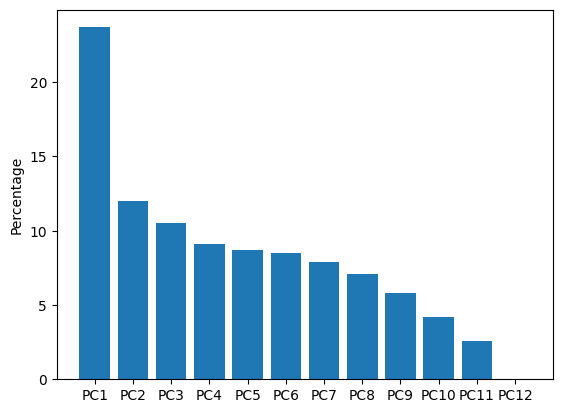

In [7]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage')
plt.show()

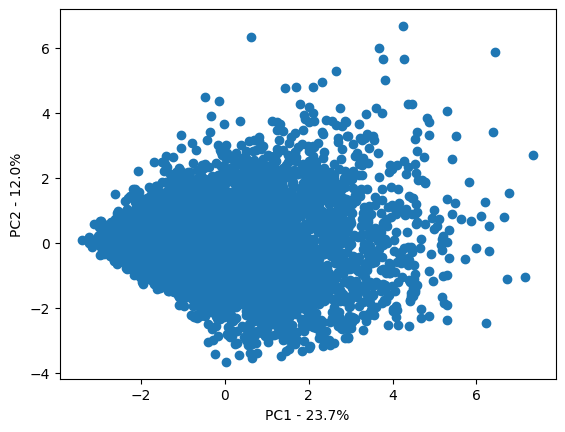

In [8]:
pca_df = pd.DataFrame(pca_data, index=df.index, columns=labels)
pca_df
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

plt.show()

In [9]:
df = df.reset_index() # now I don't have to rerun it all every time, it's required for the cell bellow

In [10]:
# damn, all the renaming brings lots of mess, fix it please
orders = meta_df['Order'].to_list()
df = df.rename(columns={'index':'Species'})
df['Orders'] = orders
reducer = umap.UMAP(random_state=1)
df_data = df[muts].values
scaled_data = preprocessing.StandardScaler().fit_transform(df_data)
embed = reducer.fit_transform(scaled_data)


In [11]:
df

,Species,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,Orders
0,Abagrotis_variata,0.000000,0.037913,0.161777,0.146494,0.0,0.470835,0.000000,0.0,0.0,0.114481,0.068500,0.000000,Lepidoptera_7088
1,Abantiades_argentata,0.000000,0.038948,0.000000,0.000000,0.0,0.180528,0.751433,0.0,0.0,0.000000,0.020485,0.008606,Lepidoptera_7088
2,Abantiades_atripalpis,0.000000,0.038566,0.024528,0.000000,0.0,0.248005,0.630421,0.0,0.0,0.024086,0.026273,0.008122,Lepidoptera_7088
3,Abantiades_obscura,0.011137,0.037635,0.024054,0.000000,0.0,0.390091,0.397633,0.0,0.0,0.038500,0.086887,0.014063,Lepidoptera_7088
4,Abia_aenea,0.000000,0.039591,0.027136,0.000000,0.0,0.142453,0.713849,0.0,0.0,0.025661,0.025614,0.025697,Hymenoptera_7399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5490,Zygaena_romeo,0.014007,0.009432,0.014008,0.000000,0.0,0.208691,0.694986,0.0,0.0,0.000000,0.058877,0.000000,Lepidoptera_7088
5491,Zygaena_transalpina,0.009992,0.043697,0.009823,0.000000,0.0,0.181844,0.734007,0.0,0.0,0.000000,0.020637,0.000000,Lepidoptera_7088
5492,Zygaena_viciae,0.000000,0.028755,0.037608,0.000000,0.0,0.108426,0.732162,0.0,0.0,0.032507,0.060541,0.000000,Lepidoptera_7088
5493,Zygaenoprocris_chalcochlora,0.000000,0.059544,0.142492,0.262823,0.0,0.293573,0.000000,0.0,0.0,0.090541,0.123283,0.027743,Lepidoptera_7088


Text(0.5, 1.0, 'UMAP projection of the 12 Mutational spectrum')

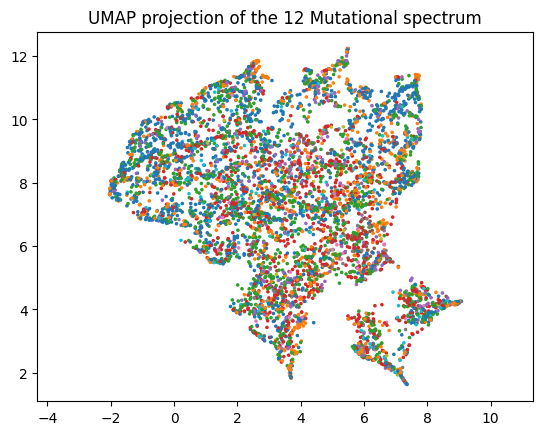

In [12]:
color_per_order = {}
orders = df['Orders'].drop_duplicates().to_list()
for i in range(len(orders)):
    color_per_order[orders[i]] = i
plt.scatter(
    embed[:, 0],
    embed[:, 1],
    c=[sns.color_palette(n_colors=23)[x] for x in df.Orders.map(color_per_order)],
    s=[2.5 for i in range(len(embed[:, 0]))]
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the 12 Mutational spectrum', fontsize=12)

(1.0, 100.0)

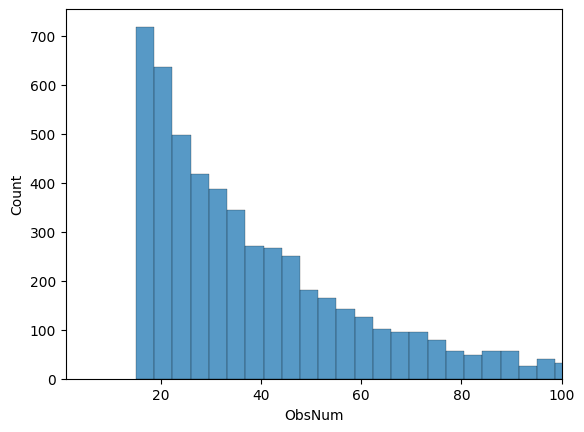

In [13]:
plotting = mutspec12.groupby(mutspec12['Species']).aggregate({'ObsNum' : 'sum'})
fig, ax = plt.subplots()
sns.histplot(plotting, x='ObsNum', ax=ax)
ax.set_xlim(1, 100)

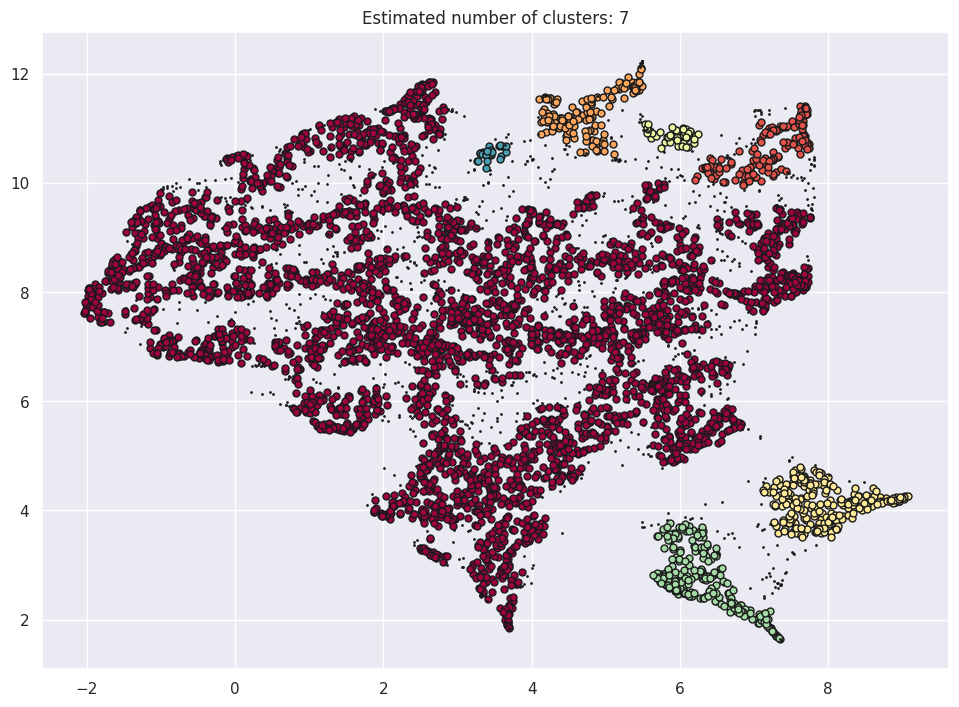

In [21]:
#DBSCAN: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
X = embed
db = DBSCAN(eps=0.3, min_samples=20).fit(X)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=5,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=1,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [22]:
# removing unnecessary clusters
orders_distribution = pd.DataFrame()
orders_distribution['Orders'] = df['Orders']
orders_distribution['Species'] = df['Species']
orders_distribution['Cluster'] = db.labels_
orders_distribution.drop(orders_distribution[orders_distribution.Cluster == -1].index, inplace=True)
to_remove = []
for k,v in Counter(orders_distribution['Cluster']).items():
    if v < 50:
        to_remove.append(k)

for v in to_remove:
    orders_distribution.drop(orders_distribution[orders_distribution.Cluster == v].index, inplace=True)

#getting rid of 4 major orders for future use
orders_distribution_without_4_majors = orders_distribution
orders_distribution_without_4_majors = orders_distribution_without_4_majors.loc[~((orders_distribution_without_4_majors['Orders'] == 'Lepidoptera_7088') | 
(orders_distribution_without_4_majors['Orders'] == 'Coleoptera_7041') | (orders_distribution_without_4_majors['Orders'] == 'Hymenoptera_7399') | 
(orders_distribution_without_4_majors['Orders'] == 'Diptera_7147'))]

In [23]:
# renaming orders that contribute less than 10% to distribution in respective clusters as 'Others'
order_and_cluster = []
for i in range(len(orders_distribution['Orders'])):
    order_and_cluster.append(f'{orders_distribution["Orders"].to_list()[i]}:{orders_distribution["Cluster"].to_list()[i]}')
cluster_counts = orders_distribution['Cluster'].value_counts().to_dict()
to_rename= {}
for order_cluster, count in Counter(order_and_cluster).items():
    if count/cluster_counts[int(order_cluster.split(':')[1])] <= 0.1:
        to_rename[order_cluster] = int(order_cluster.split(':')[1])
for order, cluster in to_rename.items():
    order = order.split(':')[0]
    orders_distribution['Orders'] = np.where((orders_distribution['Orders'] == order) & (orders_distribution['Cluster'] == cluster), 'Other', orders_distribution['Orders'])

#same for df without 4 major orders
order_and_cluster = []
for i in range(len(orders_distribution_without_4_majors['Orders'])):
    order_and_cluster.append(f'{orders_distribution_without_4_majors["Orders"].to_list()[i]}:{orders_distribution_without_4_majors["Cluster"].to_list()[i]}')
cluster_counts = orders_distribution_without_4_majors['Cluster'].value_counts().to_dict()
to_rename= {}
for order_cluster, count in Counter(order_and_cluster).items():
    if count/cluster_counts[int(order_cluster.split(':')[1])] <= 0.05:
        to_rename[order_cluster] = int(order_cluster.split(':')[1])
for order, cluster in to_rename.items():
    order = order.split(':')[0]
    orders_distribution_without_4_majors['Orders'] = np.where((orders_distribution_without_4_majors['Orders'] == order) & (orders_distribution_without_4_majors['Cluster'] == cluster), 'Other', orders_distribution_without_4_majors['Orders'])

/tmp/ipykernel_2707/467961664.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_distribution_without_4_majors['Orders'] = np.where((orders_distribution_without_4_majors['Orders'] == order) & (orders_distribution_without_4_majors['Cluster'] == cluster), 'Other', orders_distribution_without_4_majors['Orders'])


Text(37.97661111111111, 0.5, 'Relative number of Orders')

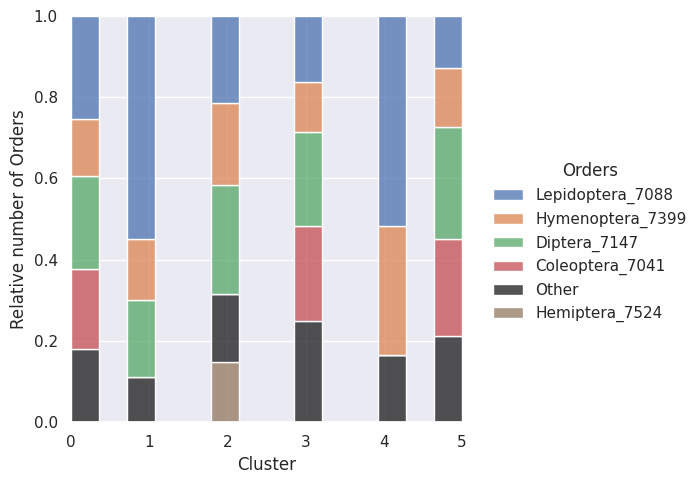

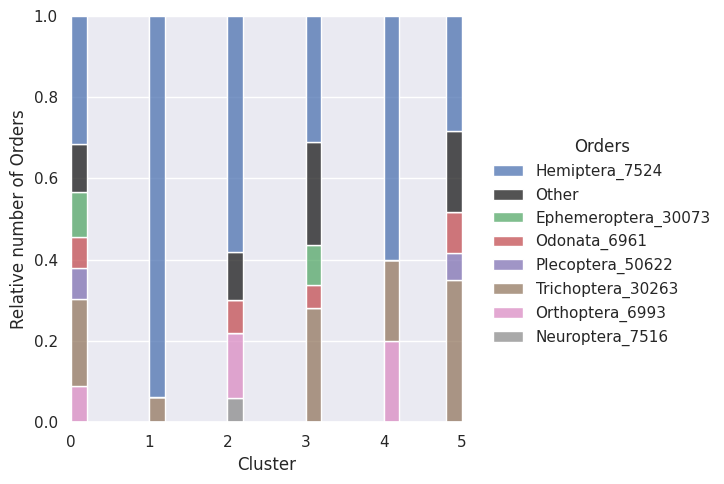

In [24]:
#plotting cluster distrebution w/ 4 major orders
unique = orders_distribution['Orders'].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
palette.update({"Other":"k"})

sns.displot(orders_distribution, x='Cluster', hue='Orders', multiple='fill', palette=palette)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(orders_distribution['Cluster'].drop_duplicates().to_list())
plt.ylabel('Relative number of Orders')

#plotting cluster distrebution w/o 4 major orders
unique = orders_distribution_without_4_majors['Orders'].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
palette.update({"Other":"k"})

sns.displot(orders_distribution_without_4_majors, x='Cluster', hue='Orders', multiple='fill', palette=palette, binwidth=0.2)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(orders_distribution['Cluster'].drop_duplicates().to_list())
plt.ylabel('Relative number of Orders')

In [18]:
#adding cluster number into mutspec tables and exporting it for drawing mutspecs filtered by clusters (otherwise I have to downgrade umap and dbscan which leads to fucking up clusterization)
mutspec12['Cluster'] = np.nan
for sp_cluster_pair in orders_distribution.values:
    mutspec12['Cluster'] = np.where((mutspec12['Species'] == sp_cluster_pair[1]), sp_cluster_pair[2], mutspec12['Cluster'])
mutspec12 = mutspec12.dropna()
mutspec12.to_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutstep-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/ms12syn_internal_clusters_iqtree.tsv', sep='\t')


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 1 clusters is 70586.12
The within cluster sum of squares for 2 clusters is 40584.56


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 3 clusters is 23690.53
The within cluster sum of squares for 4 clusters is 18024.68


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 5 clusters is 14432.62
The within cluster sum of squares for 6 clusters is 11397.75


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 7 clusters is 9223.82


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 8 clusters is 7980.20


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 9 clusters is 6920.15


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 10 clusters is 6254.15
The within cluster sum of squares for 11 clusters is 5618.01


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 12 clusters is 5092.07


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 13 clusters is 4664.65


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 14 clusters is 4252.56


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 15 clusters is 3917.49


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 16 clusters is 3584.23


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 17 clusters is 3362.00


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 18 clusters is 3159.43


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 19 clusters is 2961.37


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 20 clusters is 2790.78


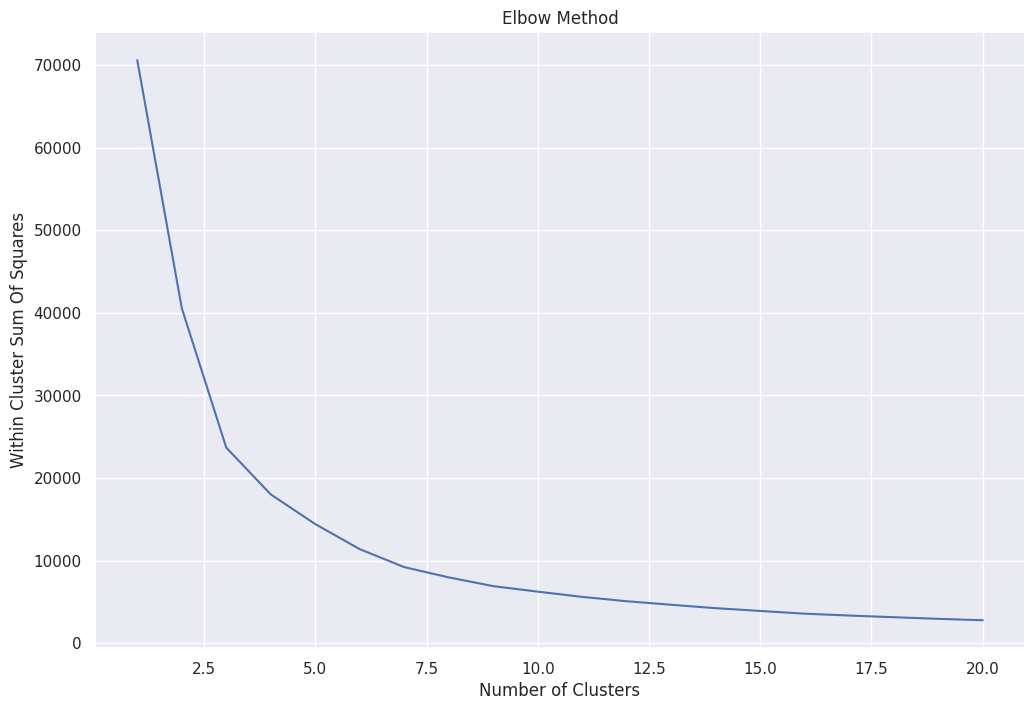

In [75]:
# Create an empty dictionary to save the within cluster sum of square values
wcss = {} 
# Look through the number of clusters
for i in range(1,21):
  # Run kmeans model
  kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
  #Sum of squared distances of samples to their closest cluster center.
  wcss[i] = (kmeans.inertia_)
  # Print the within cluster sum of squares for each cluster number
  print(f'The within cluster sum of squares for {i} clusters is {wcss[i]:.2f}')

  # Visualization
plt.figure(figsize=(12,8))
plt.plot(list(wcss.keys()),list(wcss.values()))
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum Of Squares')
plt.show()

/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 2 clusters is 0.377


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 3 clusters is 0.424


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 4 clusters is 0.412


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 5 clusters is 0.390


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 6 clusters is 0.403


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 7 clusters is 0.412


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 8 clusters is 0.415


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 9 clusters is 0.416


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 10 clusters is 0.412


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 11 clusters is 0.416


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 12 clusters is 0.406


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 13 clusters is 0.408


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 14 clusters is 0.395


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 15 clusters is 0.400


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 16 clusters is 0.404


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 17 clusters is 0.407


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 18 clusters is 0.406


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 19 clusters is 0.410


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 20 clusters is 0.411


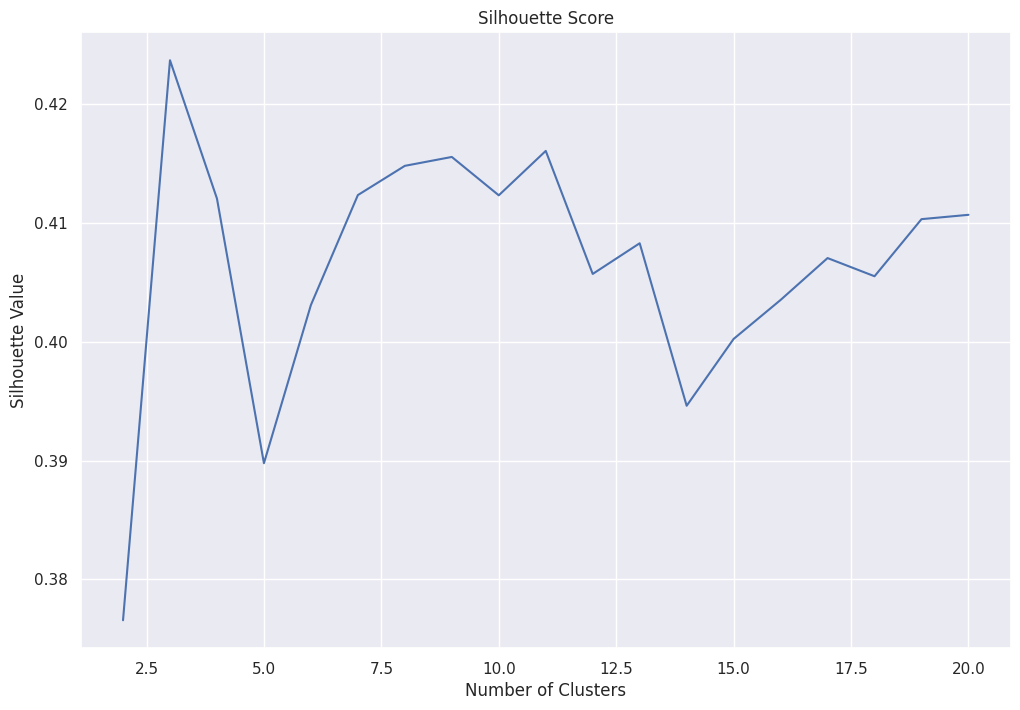

In [76]:
# Create an empty dictionary for the Silhouette score
s_score = {} 
# Loop through the number of clusters
for i in range(2,21): # Note that the minimum number of clusters is 2
  # Fit kmeans clustering model for each cluster number
  kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
  # Make prediction
  classes = kmeans.predict(X)
  # Calculate Silhouette score
  s_score[i] = (silhouette_score(X, classes)) 
  # Print the Silhouette score for each cluster number
  print(f'The silhouette score for {i} clusters is {s_score[i]:.3f}') 
  # Visualization
plt.figure(figsize=(12,8))
plt.plot(list(s_score.keys()),list(s_score.values()))
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Value')
plt.show()